In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Overview

In this notebook, we are going to explore the Least Square Regression (LSR) model. The main goals of this notebook are:

- Learn how to use the plug-and-play models implemented in the Python package sklearn.
- Explore the Noise-Bias-Variance Decomposition.
- Check if our estimator is unbiased.
- How to detect overfitting.
- How to avoid overfitting: regularization.


# Generating some data

First, we are going to create the functions to generate linear and sinusoidal data in the interval $x \in [0,1 ]$, adding gaussian noise.

**Linear data**: $y = wx + b + \epsilon$ with $\epsilon \sim N(0, \sigma)$

**Sinosoidal data**: $y = sin(2\pi x) + \epsilon$ with $\epsilon \sim N(0, \sigma)$

$\sim$ means "*distributed according to*"

In [2]:
# Generate data in the interval [0,1]
def make_linear_data(num_points, w, b, noise_std):
  x = np.sort(np.random.uniform(low=0, high=1, size=num_points)) # result is of shape (num_points,) and sorted in ascending order
  epsilon = np.random.normal(loc=0, scale=noise_std, size=num_points) # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
  y = w * x + b + epsilon
  return x, y

def make_sin_data(num_points, noise_std): 
  x = np.sort(np.random.uniform(low=0, high=1, size=num_points))
  epsilon = np.random.normal(loc=0, scale=noise_std, size=num_points)
  y = np.sin(2 * np.pi * x) + epsilon 
  return x,y


w_true = 2
b_true = 1
x_linear, y_linear =  make_linear_data(100, w=w_true, b=b_true, noise_std=0.2)

x_sinus, y_sinus = make_sin_data(100, noise_std=1)

To visualize the datasets these functions produce, we can plot them:

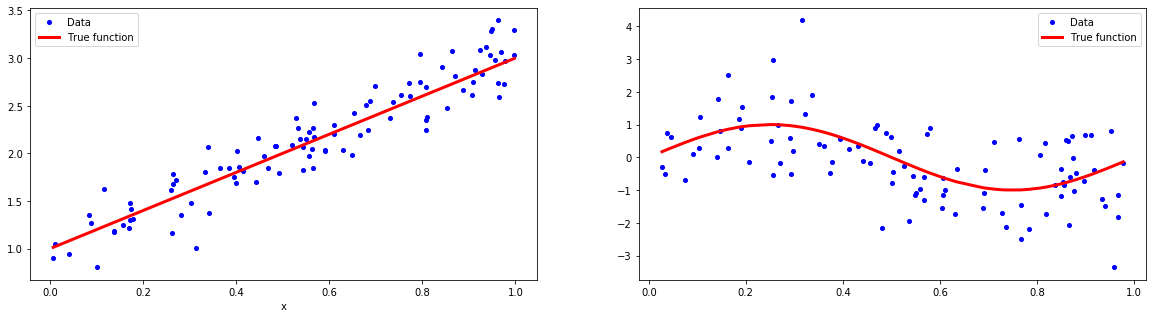

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(x_linear,y_linear,"bo",markersize=4, label="Data")
ax1.plot(x_linear,w_true*x_linear+b_true,"red", linewidth=3, label="True function" )
ax1.set_xlabel('x')
ax1.legend()

# sinusoidal data:
ax2.plot(x_sinus,y_sinus,"bo",markersize=4, label="Data")
ax2.plot(x_sinus,np.sin(2 * np.pi * x_sinus),"red", linewidth=3, label="True function" )
ax2.legend()
f.show()


# Least Squares Regression (LSR)
Given a dataset with $n$ i.i.d. training samples $D = (X_i, Y_i)_{i=1}^n$ and a function space $\mathcal{F}$ we define the least squares regression solution as 

$$
f_{n}^{*}=\underset{f \in \mathcal{F}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}\right)\right)^{2}
$$

We also know that the optimal solution to LSR, i.e., the Bayes optimal function, is given by 

$$
f^{*}(\mathbf{x})=\mathbb{E}[Y \mid X=\mathbf{x}]
$$

Here we are looking at linear LSR, which assumes that the function class consists of all linear functions.
$$
\mathcal{F}=\left\{f: \mathbb{R}^{M} \rightarrow \mathbb{R}, f(\mathbf{x})=\sum_{i=1}^{M} w_{i} \phi_{i}(\mathbf{x}) \mid \mathbf{w} \in \mathbb{R}^{M}\right\},
$$

where $\phi_i$ are called basis functions $\phi_i: \mathbb{R}^d \rightarrow \mathbb{R}$ and represent transformations of the input data. Some examples of basis functions are 

$$
\phi(x) =  \Big( 1, x, x^2, \dots \Big) \\
\phi(x) =  \Big( sin(x), cos(x), \dots \Big)
$$

Note that, although clearly the basis functions produce vectors with entries that are non-linear with respect to their input, the function class still only contains linear functions (linear w.r.t the basis function entries).

### LSR solution
As seen in the lecture (slied L05&L06, slide-no. 10), we have an explicit solution:

Let $X\in \mathcal R^{n \times M}$. Here, we assume that the first column of this matrix is full of ones, this will make the calculation easier.

Following the slides, we now simply compute: $w^* = (X^TX)^{-1}X^Ty$. Note that we can only compute the inverse of $X^TX$, if it is of full column rank. Otherwise, we must resort to the pseudo-inverse. This problem can be circumvented by using the numpy function "pinv", which equals the normal inverse if the input is invertible and returns the pseudoinverse otherwise.



In [4]:
def LSR_optimal_w_and_b(X,y):
  X = np.vstack([np.ones(len(X)), X]).T # add ones to first column
  XTX = np.dot(X.T, X)
  XTX_inverse = np.linalg.pinv(XTX) 
  b,w = np.dot(XTX_inverse, np.dot(X.T, y)) # extract intercept and w-value from the solution

  return b,w

### Applying to linear data

Now we can apply our function to our datasets and plot the resulting solutions:

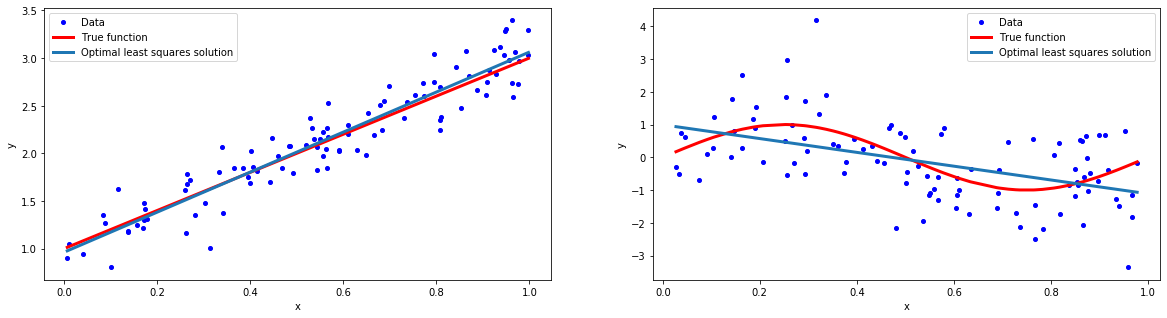

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

# Linear data:
b_opt_linear, w_opt_linear = LSR_optimal_w_and_b(x_linear,y_linear)
ax1.plot(x_linear,y_linear,"bo",markersize=4, label="Data")
ax1.plot(x_linear,w_true*x_linear+b_true,"red", linewidth=3, label="True function" )
ax1.plot(x_linear, w_opt_linear*x_linear+b_opt_linear, linewidth=3, label="Optimal least squares solution")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

# Sinusoidal data:
b_opt_sinus, w_opt_sinus = LSR_optimal_w_and_b(x_sinus,y_sinus)
ax2.plot(x_sinus,y_sinus,"bo",markersize=4, label="Data")
ax2.plot(x_sinus,np.sin(2 * np.pi * x_sinus),"red", linewidth=3, label="True function" )
ax2.plot(x_sinus, w_opt_sinus*x_sinus+b_opt_sinus, linewidth=3, label="Optimal least squares solution")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend()
f.show()

## Noise-Bias-Variance Decomposition

The risk (i.e., the expected squared loss) $R(f_n)$ of the estimator $f_n$ is given by:


$$
R(f_n) =  \mathbb{E}\left[ \left( Y-f_{n}(X)\right)^{2}\right]  =  \mathbb{E}\left[(Y-\mathbb{E}[Y \mid X])^{2}\right]+\mathbb{E}\left[\left(\mathbb{E}[Y \mid X]-f_{n}(X)\right)^{2}\right]
$$

In this first case, we left the estimator $f_n$ fixed. But, since $f_n$ is dependend on the sampled data $X$, we can also look at the "expected risk", taking into considerations the probabilities with which we sample every possible dataset (of size n): 

\begin{align}
\mathbb{E}_{D}\left[R\left(f_{n}\right)\right]&=\mathbb{E}\left[\left(Y-f^{*}(X)\right)^{2}\right]+\mathbb{E}_{D}\left[\mathbb{E}_{X}\left[\left(f^{*}(X)-f_{n}(X)\right)^{2}\right]\right] \\
 &=\mathbb{E}\left[\left(Y-f^{*}(X)\right)^{2}\right]+\operatorname{Var}\left(f_{n}(X)\right)+\left(\operatorname{Bias}\left(f_{n}(X)\right)\right)^{2} \\
 &= \sigma^2+\operatorname{Var}\left(f_{n}(X)\right)+\left(\operatorname{Bias}\left(f_{n}(X)\right)\right)^{2}
\end{align}

Here, we wrote $f^{*}(X)$ instead of $\mathbb{E}[Y \mid X]$ for easier readbility. For a derivation of these equations, refer to the slides (L05&L06, slideno. 22). The $\sigma$ corresponds to the standard deviation we used to generate the noise.

**KEY POINT 1.** The first term is called "*noise term*" or "*irreducible error*". It is constant, i.e. it doesn't depend on the sampled dataset nor on the estimator.

**KEY POINT 2.** The trade-off between (squared) bias and variance corresponds to the trade-off between overfitting and underfitting.

### Relation to regularization:

This also is related to regularization: when using regularization in least squares regression (e.g. as we do in Lasso or Ridge Regression), we will introduce some bias (whereas the ordinary least squares regression provides unbiased estimates), but in turn we can greatly reduce variance and thus produce superior performance in general. 

# Linear data with varying amounts of noise 
Intuitively, it should be clear that our estimator has larger variance if either the variance of the noise increases or the number of samples in the dataset decreases.

We can test this intuition by looking at the best values of w and b, as well as the MSE, for varying levels of noise and dataset sizes:

In [6]:
# Mean Squared Error (MSE) a.k.a. Risk of squared loss
def MSE(ground_truth, prediction):
  return np.mean(np.square(ground_truth - prediction))

In [7]:
# one could also show that even for large variance, the correct coeff are found as n -> \infty
num_samples = 6
noise_std = 2
x_data, y_data = make_linear_data(num_samples, w=2,b=1,noise_std=noise_std)
reg = LinearRegression().fit(x_data.reshape(-1, 1), y_data)
x_data, y_data = make_linear_data(num_samples*10000, w=2,b=1,noise_std=noise_std)

prediction = reg.predict(x_data.reshape(-1, 1))
loss = MSE(y_data,prediction)

print(f"w_star: {reg.coef_[0]:.3f}")
print(f"b_star: {reg.intercept_:.3f}")
print(f"MSE: {loss:.3f} | Irreducible error: {noise_std**2:.3f}")

w_star: 1.141
b_star: 2.304
MSE: 4.854 | Irreducible error: 4.000


### Visualizing the distributions of $w^*$ and $b^*$

To get a better look at how much the $w^*$ and $b^*$ vary with different datasets, we can run a more thorough experiment:

Questions we might ask is:
1.   Is our estimator unbiased?

    -> Do our samples on expectation match the true w and b that were used for generating the data?
2.   How does the estimator change with n (dataset size)

    -> We can plot a histogram to find out how it is distributed

E[w*] is approximately 1.994, the true value is 2. Var[w*] is approximately 0.120.
E[b*] is approximately 1.002, the true value is 1. Var[b*] is approximately 0.041.



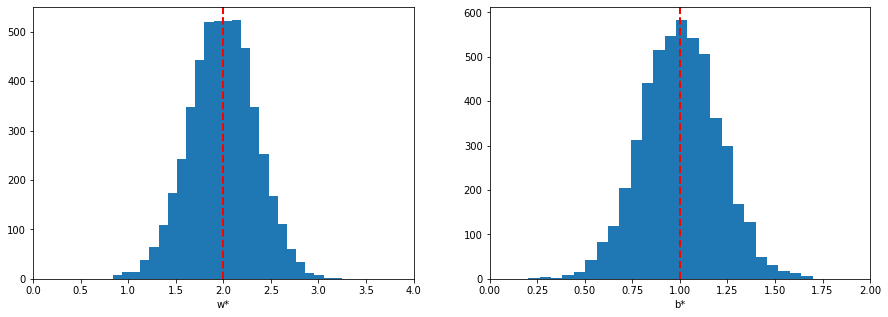

In [8]:
w_true, b_true, noise_std = 2, 1, 1

N = 100 # Number of datapoints per dataset

W_stars, B_stars = [], []

for m in range(5000): # Changing this value does not change the distribution.
  x_data, y_data = make_linear_data(N, w_true, b_true, noise_std)
  reg = LinearRegression().fit(x_data.reshape(-1, 1), y_data)
  W_stars.append(reg.coef_[0]) # Extract w_star from the result
  B_stars.append(reg.intercept_) # Extract b_star from the result

print(f'E[w*] is approximately {np.mean(W_stars):.3f}, the true value is {w_true}. Var[w*] is approximately {np.var(W_stars, ddof=1):.3f}.')
print(f'E[b*] is approximately {np.mean(B_stars):.3f}, the true value is {b_true}. Var[b*] is approximately {np.var(B_stars, ddof=1):.3f}.\n')


fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(W_stars, bins=25, density=False)
ax[0].axvline(w_true, color='r', linestyle='dashed', linewidth=2)
ax[0].set_xlabel("w*")

ax[1].hist(B_stars, bins=25, density=False)
ax[1].axvline(b_true, color='r', linestyle='dashed', linewidth=2)
ax[1].set_xlabel("b*")

# Fix the axis such that the plots are always comparable with new data
ax[0].set_xlim([0,4])
ax[1].set_xlim([0,2])
plt.show()


Side note: remember the central limit theorem? :)

# Introducing basis functions

Basis functions can be used to apply linear regression methods, even though the relationship between the input features (x) and the outputs (target value, y) is *not* linear. We do this by transforming our input feature into a new space (of generally higher dimension) in which the relationship between the input and output is now linear.

**Example:**
For example, we can use polynomials as the basis function: $\phi(x) = [1, x, x^2, ...,  x^p]$. For example, in a 1-D regression problem, X would be $\in \mathcal R^{n\times 1}$. If we apply the above polynomial basis function (for some finite p), the new, "transformed" dataset will be of shape $X \in \mathcal R^{n \times (p+1)}$. The original one-dimensional datapoint $2$ would be transformed to the (p+1)-dimensional datapoint $(1,2,4,\dots, 2^p)$.

**Questions we might ask:**
1.   How does the training/test error vary with $p$?

    -> We can plot the MSE's (prediction vs. ground truth, for both train and test data) on the y-Axis, and p on the x-Axis. 
    
2.   How can we relate what we find to the concepts of under-/overfitting and the bias-variance trade-off?

3.   How can we pick a suitable value for $p$, without relying on the test data?


To find out more, we first write a function that gives us, for all degrees up to some limit, the train and test errors:

In [9]:
# Parameter generator: a function that takes in a size (n) and returns a dataset
# Parameter regressor: either LinearRegression or Ridge or Lasso (all are classes from sklearn)
def evaluate_models(max_p, train_data, test_data, regressor):
    x_train, y_train = train_data
    x_test, y_test = test_data

    training_errors, test_errors, models = [], [], []
    for i in range(max_p+1):
          # The [:,None] part converts from shape (n,) to shape (n,1)
          # See scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.transform
          features = PolynomialFeatures(i+1).fit(x_train[:,None]) 
          X_train = features.transform(x_train[:,None])
          X_test = features.transform(x_test[:,None])

          model = regressor().fit(X_train, y_train)
          models.append(model)

          training_errors.append(MSE(model.predict(X_train), y_train))
          test_errors.append(MSE(model.predict(X_test), y_test))
    return training_errors, test_errors, models

Now we can plot the MSE values (y-Axis) with the values for p (x-Axis):

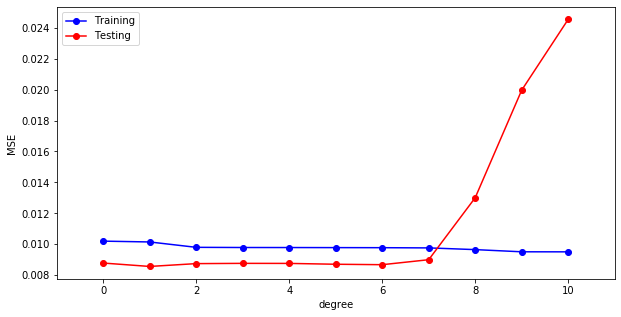

In [10]:
train_size, test_size = 50,100

w_true,b_true,std = 2,1,0.1


# generator is now a function taking only one argument (size) and passing it to make_linear_data
generator = lambda size: make_linear_data(size,w_true,b_true,std) 
regressor = LinearRegression

train_data = generator(train_size)
test_data = generator(test_size)

max_p=10
training_errors, test_errors, models = evaluate_models(max_p,train_data,test_data,regressor)

plt.figure(figsize=(10,5))
plt.plot(training_errors, 'bo-', label="Training")
plt.plot(test_errors, 'ro-', label="Testing")
plt.legend()
plt.xlabel("degree")
plt.ylabel("MSE")
plt.xlim(-1,max_p+1)
plt.show()

For the higher values of p, we observe overfitting!


# Model selection using the sinusoidal data

We can perform a similar analysis for the sinusoidal data:

In [11]:
def plot_error_curves(train_errors, test_errors, ax = None, max_p=10):
  if ax is None:
    ax = plt.gca()
  ax.plot(train_errors, 'bo-', label="Training")
  ax.plot(test_errors, 'ro-', label="Testing")
  ax.legend()
  ax.set_xlabel("degree")
  ax.set_ylabel("MSE")
  ax.set_xlim(-1,max_p+1)

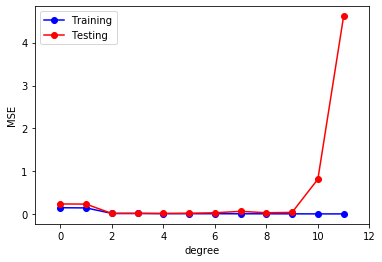

In [12]:
std=0.15
train_size, test_size = 20,50
generator = lambda size: make_sin_data(size,std)
regressor = LinearRegression
train_data = generator(train_size)
test_data = generator(test_size)

max_p = 11
training_errors, test_errors, models = evaluate_models(max_p,train_data,test_data,regressor)
plot_error_curves(training_errors, test_errors, max_p=max_p)


Clearly, we observe overfitting. We can use regularization to combat this:

**TODO.** Why is the training and test MSE very high with p<2?

## Regularization: Ridge and Lasso

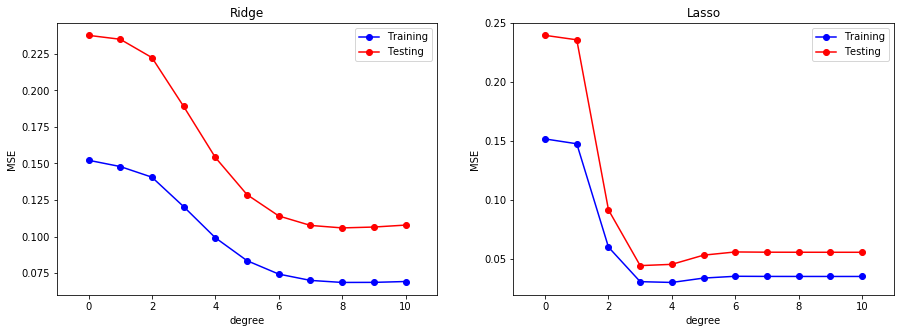

In [13]:
generator = lambda size: train_data if size==train_size else test_data

ridge_regressor = lambda: Ridge(alpha=0.05)
lasso_regressor = lambda: Lasso(alpha=0.001)

max_p = 10
ridge_train_error, ridge_test_error, ridge_models = evaluate_models(max_p,train_data,test_data,ridge_regressor)
lasso_train_error, lasso_test_error, lasso_models = evaluate_models(max_p,train_data,test_data,lasso_regressor)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title("Ridge")
axes[1].set_title("Lasso")
plot_error_curves(ridge_train_error, ridge_test_error, axes[0], max_p=max_p)
plot_error_curves(lasso_train_error, lasso_test_error, axes[1], max_p=max_p)

From these plots, we see that we can indeed prevent overfitting when using regularization.

## Plotting the predictions

To finish up, we can plot the predictions on some test data, for both our Lasso and Ridge models:

In [14]:
def plot_predictions(ridge_models, lasso_models,axes, test_data, true_values, train_data, name_left_plot='Ridge'):
  for i,(ridge_model, lasso_model) in enumerate(zip(ridge_models,lasso_models)):
    feature = PolynomialFeatures(i+1).fit(x_test[:,None])
    X_test = feature.transform(x_test[:,None])

    lasso_pred = lasso_model.predict(X_test)    
    ridge_pred = ridge_model.predict(X_test)

    axes[i,0].set_title("Ridge with Polynomial of degree %d" % (i+1))
    axes[i,0].set_title(f"{name_left_plot} with Polynomial of degree {i+1}")
    axes[i,0].plot(true_values[0], true_values[1],"black", label="True process")
    axes[i,0].plot(train_data[0],train_data[1],"bo",label="Train data")
    axes[i,0].plot(test_data[0],test_data[1],"ro",label="Test data")
    axes[i,0].plot(x_test, ridge_pred, "k--", label ="Model")
    axes[i,0].legend()

    axes[i,1].set_title("Lasso with Polynomial of degree %d" % (i+1))
    axes[i,1].plot(true_values[0], true_values[1],"black", label="True process")
    axes[i,1].plot(train_data[0],train_data[1],"bo",label="Train data")
    axes[i,1].plot(test_data[0],test_data[1],"ro",label="Test data")
    axes[i,1].plot(x_test, lasso_pred, "k--", label ="Model")
    axes[i,1].legend()

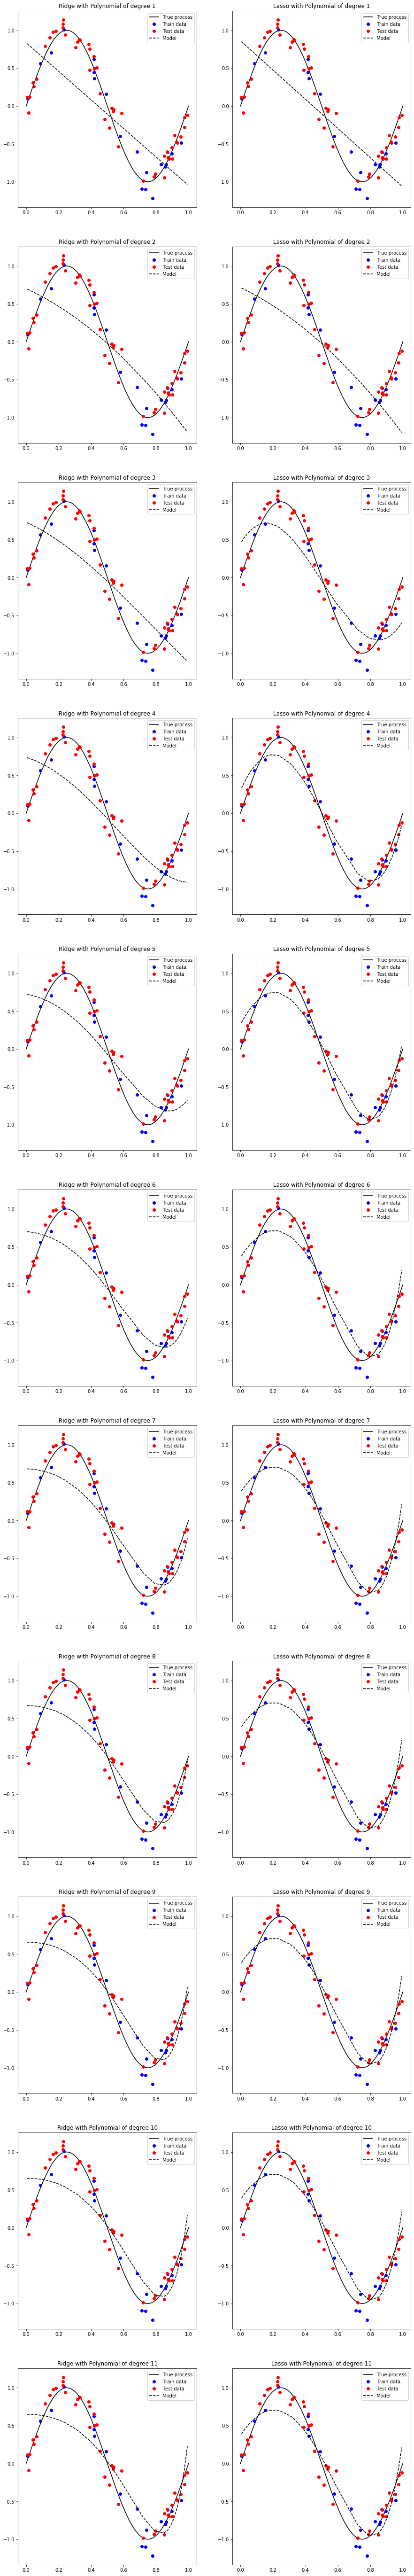

In [15]:
x = np.linspace(0, 1, 1000)
true_values = [x, np.sin(2 * np.pi * x)]
x_test = test_data[0]
x_train = train_data[0]
fig, axes = plt.subplots(max_p+1,2,figsize=(15,100))
plot_predictions(ridge_models, lasso_models, axes, test_data, true_values, train_data)

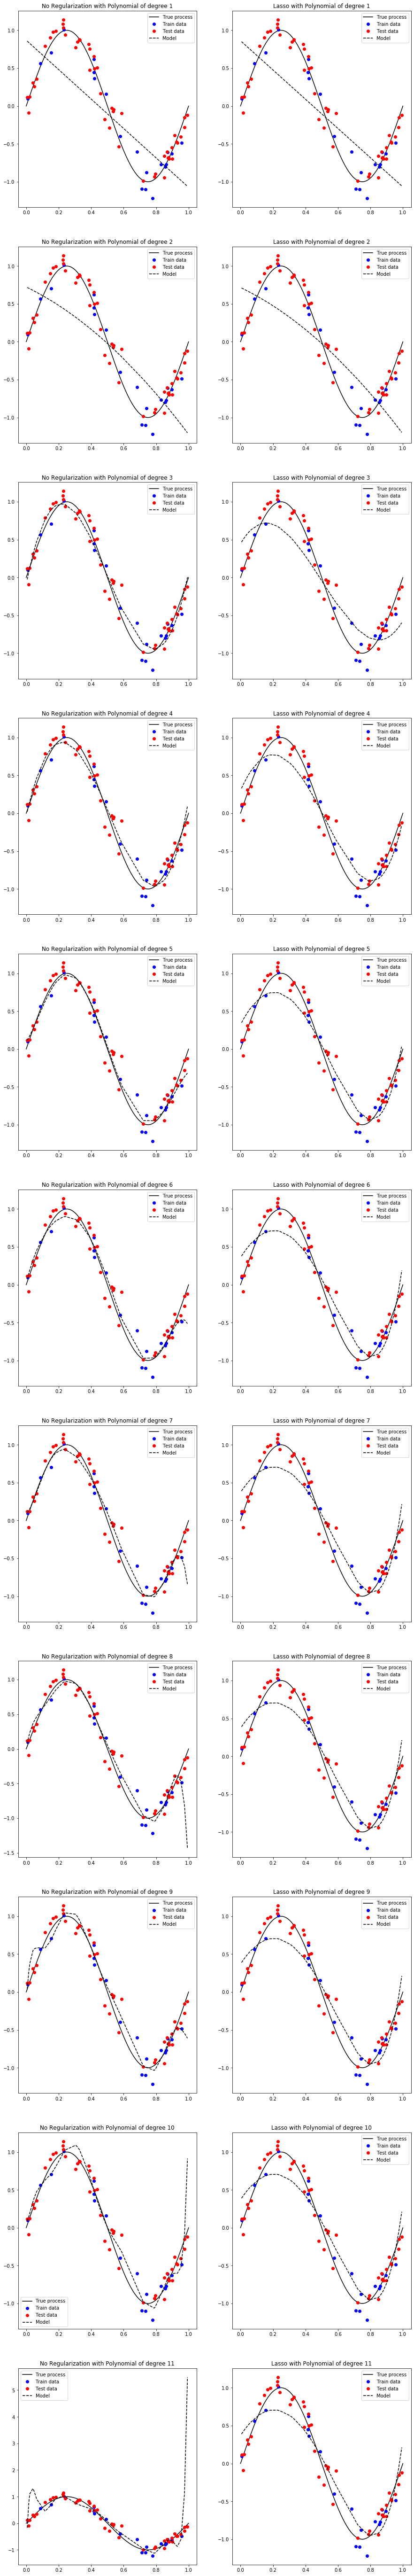

In [16]:
# TODO: print test and train points
fig, axes = plt.subplots(max_p+1,2,figsize=(15,100))

plot_predictions(models, lasso_models, axes, test_data, true_values, train_data, name_left_plot='No Regularization')

## Comparing the learned parameters of Ridge and Lasso:

As you might know, using the L1 norm as regularization (Lasso) produces parameters that are more sparse. We can confirm this by plotting histograms of the parameters:

In [17]:
def plot_parameter(ridge_models, lasso_models,axes):
  for i,(ridge_model, lasso_model) in enumerate(zip(ridge_models,lasso_models)):
    ridge_coeff = ridge_model.coef_
    lasso_coeff = lasso_model.coef_
    axes[i,0].set_title("Ridge with Polynomial of degree %d" % (i+1))
    axes[i,0].bar(range(len(ridge_coeff)),ridge_coeff,width=0.5)
    axes[i,1].set_title("Lasso with Polynomial of degree %d" % (i+1))
    axes[i,1].bar(range(len(lasso_coeff)),lasso_coeff, width=0.5)

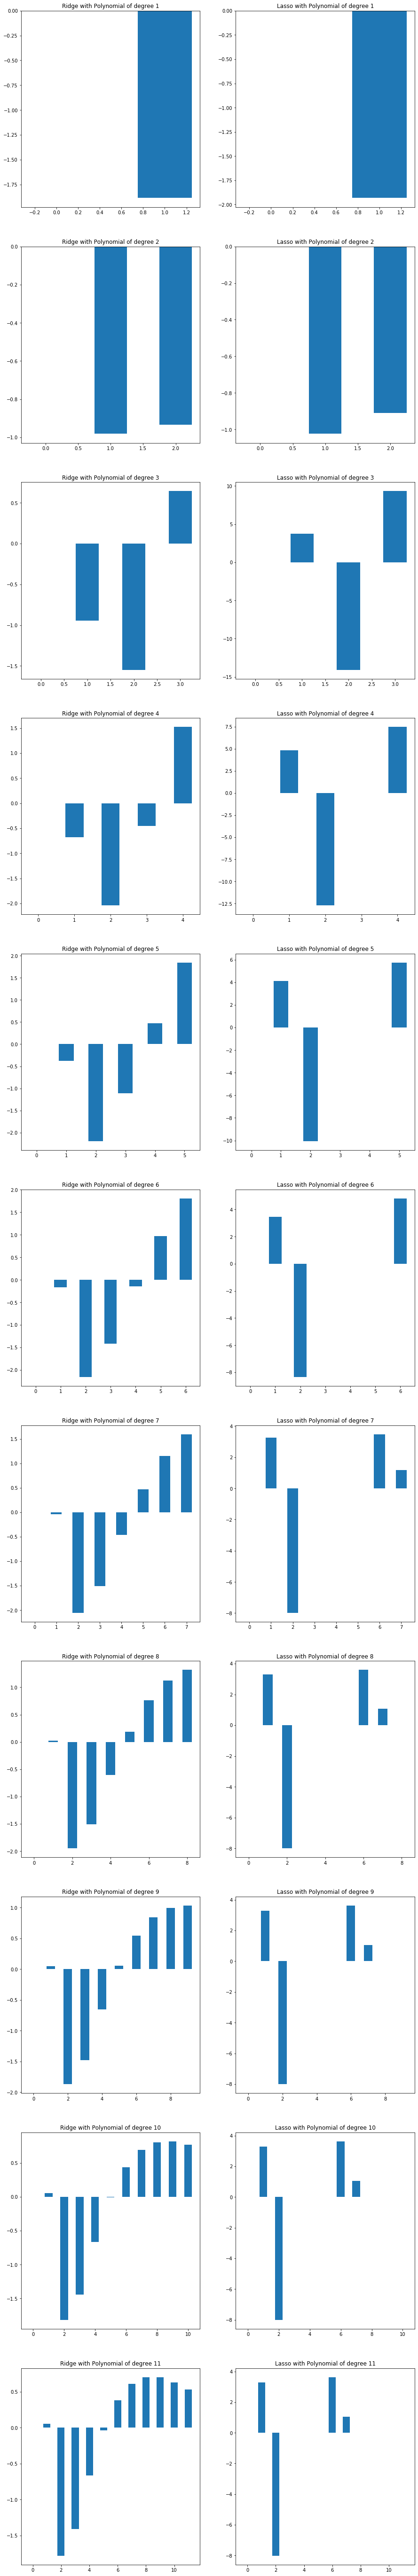

In [18]:
fig, axes = plt.subplots(max_p+1,2,figsize=(15,100))
plot_parameter(ridge_models, lasso_models, axes)

**TODO.** Plot the regularization parameter lambda (alpha in the sklearn object) in the x-axis versus the training/test MSE in the y-axis for different values of p (degree of the polynomial). For which values of lambda does overfitting happen? and underfitting?